In [1]:
%matplotlib inline

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F


import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.optim as optim
import cv2

# from LFWDataset import LFWDataset
# from SiameseNet import SiameseNet

In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
class LFWDataset(Dataset):
    
    """Faces in the wild dataset."""

    def __init__(self, root_dir='lfw/', train=False, test=False, transform=None):
        self.train = train
        self.test = test
        self.root_dir = root_dir
        self.files = []
        self.labels = []
        self.transform = transform
        
        if (self.train and self.test) or not (self.train or self.test):
            raise ValueError('Exactly one of train and test must be set.')
        
        """
        Getting Train/Test splits
        """
        dataset = set()
        if self.train:
            filename='train.txt'
        else:
            filename='test.txt'

        with open(filename) as f:
            for line in f:
                line = line.split()
                self.files.append(line[:2])
                self.labels.append(int(line[2]))
                
        #print(self.files)
    
    def __len__(self):
        return len(self.files)
#         return sum([len(files) for r, d, files in os.walk(self.root_dir)])
#         https://stackoverflow.com/questions/16910330/return-number-of-files-in-directory-and-subdirectory

    def __getitem__(self, idx):
        im_names = self.files[idx]
        im1 = Image.open(os.path.join(self.root_dir, im_names[0]))
        im2 = Image.open(os.path.join(self.root_dir, im_names[1]))
        label = self.labels[idx]
        
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
            
        return im1, im2, label

In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class SiameseNet(nn.Module):

    def __init__(self):
        super(SiameseNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=(1,1), padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2), stride=(2,2)),
            
            nn.Conv2d(64, 128, 5, stride=(1,1), padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2,2), stride=(2,2)),
            
            nn.Conv2d(128, 256, 3, stride=(1,1), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d((2,2), stride=(2,2)),
            
            nn.Conv2d(256, 512, 3, stride=(1,1), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 16 * 16, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(2*1024, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        output = self.cnn(x)
        #flatten
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output        

    def forward(self, input1, input2):
        f1 = self.forward_once(input1)
        f2 = self.forward_once(input2)
#         print(f1, f2)
        output = self.fc2(torch.cat((f1, f2), 1))
        return output


In [13]:
%matplotlib inline
def show(img, filename=None, save=False):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()
    if save and filename is not None:
        plt.savefig(filename)

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

In [65]:
trainset = LFWDataset(train=True,
                      transform=transforms.Compose([transforms.Scale((128,128)),
                                                                      transforms.ToTensor()
                                                                      ]))
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)




In [6]:
# vis_dataloader = DataLoader(trainset,
#                         shuffle=True,
#                         num_workers=8,
#                         batch_size=8)
# dataiter = iter(vis_dataloader)

# example_batch = next(dataiter)
# concatenated = torch.cat((example_batch[0],example_batch[1]),0)

# show(torchvision.utils.make_grid(concatenated))
# print(example_batch[2].numpy())

In [71]:
net = SiameseNet().cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-6
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [72]:
print(net)

SiameseNet (
  (cnn): Sequential (
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU (inplace)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU (inplace)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (7): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (11): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  )
  (fc1): Sequential (
    (0): Linear (131072 -> 1024)
    (1): ReLU (inplace)
    (2): BatchNorm2d(1024, 

In [73]:
counter = []
loss_history = [] 
iteration_number= 0
epochs = 100

In [74]:
for epoch in range(epochs):
    for i, data in enumerate(trainloader,0):
        img0, img1, label = data 
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        
        output = net(img0,img1)
        output = torch.cat((output, 1-output), 1)
        #output is of the form [similarity, 1-similarity]
        #closer to [1, 0] is same face, [0, 1] is different face.
                
        optimizer.zero_grad()
        loss = criterion.forward(output, label)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss.data[0]))
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss.data[0])
            

Epoch number 0
 Current loss 0.701419591904

Epoch number 0
 Current loss 0.688651204109

Epoch number 0
 Current loss 0.682772099972

Epoch number 0
 Current loss 0.722647666931

Epoch number 1
 Current loss 0.648253560066

Epoch number 1
 Current loss 0.6255428195

Epoch number 1
 Current loss 0.627396821976

Epoch number 1
 Current loss 0.610341310501

Epoch number 2
 Current loss 0.612944424152

Epoch number 2
 Current loss 0.582180857658

Epoch number 2
 Current loss 0.581018149853

Epoch number 2
 Current loss 0.596436202526

Epoch number 3
 Current loss 0.538316965103

Epoch number 3
 Current loss 0.535675048828

Epoch number 3
 Current loss 0.543514728546

Epoch number 3
 Current loss 0.536738932133

Epoch number 4
 Current loss 0.535087823868

Epoch number 4
 Current loss 0.531438529491

Epoch number 4
 Current loss 0.513570189476

Epoch number 4
 Current loss 0.522263407707

Epoch number 5
 Current loss 0.488791406155

Epoch number 5
 Current loss 0.50958365202

Epoch number 

Epoch number 45
 Current loss 0.333851933479

Epoch number 45
 Current loss 0.326376914978

Epoch number 45
 Current loss 0.332216382027

Epoch number 45
 Current loss 0.327900677919

Epoch number 46
 Current loss 0.328181117773

Epoch number 46
 Current loss 0.32725957036

Epoch number 46
 Current loss 0.329260438681

Epoch number 46
 Current loss 0.328396111727

Epoch number 47
 Current loss 0.332577228546

Epoch number 47
 Current loss 0.327203035355

Epoch number 47
 Current loss 0.327204674482

Epoch number 47
 Current loss 0.330403447151

Epoch number 48
 Current loss 0.342728465796

Epoch number 48
 Current loss 0.326999098063

Epoch number 48
 Current loss 0.326657474041

Epoch number 48
 Current loss 0.32992914319

Epoch number 49
 Current loss 0.334392279387

Epoch number 49
 Current loss 0.327635020018

Epoch number 49
 Current loss 0.325817167759

Epoch number 49
 Current loss 0.326175630093

Epoch number 50
 Current loss 0.328720599413

Epoch number 50
 Current loss 0.3295

Epoch number 89
 Current loss 0.31816098094

Epoch number 90
 Current loss 0.319735914469

Epoch number 90
 Current loss 0.319433897734

Epoch number 90
 Current loss 0.317344993353

Epoch number 90
 Current loss 0.319764018059

Epoch number 91
 Current loss 0.318590819836

Epoch number 91
 Current loss 0.318406075239

Epoch number 91
 Current loss 0.317612886429

Epoch number 91
 Current loss 0.318080127239

Epoch number 92
 Current loss 0.320365190506

Epoch number 92
 Current loss 0.318578481674

Epoch number 92
 Current loss 0.318559765816

Epoch number 92
 Current loss 0.319631278515

Epoch number 93
 Current loss 0.319637715816

Epoch number 93
 Current loss 0.319186240435

Epoch number 93
 Current loss 0.317769944668

Epoch number 93
 Current loss 0.317944824696

Epoch number 94
 Current loss 0.317716240883

Epoch number 94
 Current loss 0.317931175232

Epoch number 94
 Current loss 0.319959372282

Epoch number 94
 Current loss 0.319174855947

Epoch number 95
 Current loss 0.317

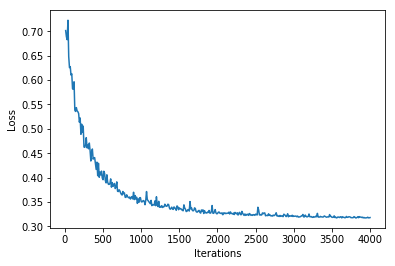

In [75]:
show_plot(counter,loss_history)

In [76]:
torch.save(net.state_dict(), "model")

In [77]:
testset = LFWDataset(test=True,
                     transform=transforms.Compose([transforms.Scale((128, 128)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

In [82]:
right=wrong=0

testnet = SiameseNet().cuda()
testnet.load_state_dict(torch.load("model"))


for i, data in enumerate(testloader,0):
    im1, im2, label = data
    label = label[0]
#     concatenated = torch.cat((im1,im2),0)
    
    output = testnet(Variable(im1).cuda(),Variable(im2).cuda())
    
    for el in output:
        if el.data[0] > 0.5:
            #predict same face
            if label == 1:
                right += 1
            else:
                wrong += 1
        else:
            #predict different
            if label == 0:
                right += 1
            else:
                wrong += 1


In [83]:
print(right, wrong, right+wrong)

(514, 486, 1000)


In [84]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive